In [0]:
import itertools
import numpy as np

import simpy
import pandas as pd

# Exercício 1

Navios chegam a um porto a intervalos de EXPO(8) horas e gastam TRI(3, 5, 10) horas para descarregar. Simule 8760 horas (1 ano). Determine os valores para:

 * Taxa de ocupação do porto;
 * Tamanho médio da fila de navios;
 * Tempo médio na fila.

In [0]:
def gen_tempo_entre_chegadas(param=8):
    return np.random.exponential(param)

def gen_tempo_descarregar(param=[3, 5, 10]):
    return np.random.triangular(*param)

esperas = []
def navio(env, doca):
    with doca.request() as req:
        chegada = env.now
        yield req
        espera = env.now - chegada
        esperas.append(espera)
        tempo_descarregar = gen_tempo_descarregar()
        yield env.timeout(tempo_descarregar)

def porto_run(env, doca):
    while True:
        env.process(navio(env, doca))
        tempo_entre_chegadas = gen_tempo_entre_chegadas()
        yield env.timeout(tempo_entre_chegadas)

env = simpy.Environment()
doca = simpy.Resource(env, capacity=1)
env.process(porto_run(env, doca))
env.run(until=8760)

pd.Series(esperas).describe().rename('em horas').to_frame()

,em horas
count,1043.000000
mean,10.207736
std,12.816346
min,0.000000
25%,0.000000
50%,5.679638
75%,14.526141
max,60.901704


# Exercício 2

Em uma fábrica de geladeiras, na seção de colocação de motores, a chegada de uma geladeira sem motor ocorre a intervalos de EXPO(50) minutos e gastam-se TRIA(25, 35, 50) minutos para o serviço. Determine o tamanho médio da fila. Simule 480 minutos (8 horas).


In [0]:
def gen_tempo_entre_chegadas(param=50):
    return np.random.exponential(param)

def gen_tempo_servico(param=[25, 35, 50]):
    return np.random.triangular(*param)

esperas = []
def geladeira(env, setor):
    with setor.request() as req:
        chegada = env.now
        yield req
        espera = env.now - chegada
        esperas.append(espera)
        tempo_servico = gen_tempo_servico()
        yield env.timeout(tempo_servico)

def servico_run(env, setor):
    while True:
        env.process(geladeira(env, setor))
        tempo_entre_chegadas = gen_tempo_entre_chegadas()
        yield env.timeout(tempo_entre_chegadas)

env = simpy.Environment()
setor = simpy.Resource(env, capacity=1)
env.process(servico_run(env, setor))
env.run(until=480)

pd.Series(esperas).describe().rename('em minutos').to_frame()

,em minutos
count,10.000000
mean,24.864133
std,22.965909
min,0.000000
25%,2.605864
50%,30.333761
75%,32.826200
max,72.536161


# Exercício 3

O gerente do depto. de RH pretende testar a estratégia para o processo de seleção de trainees deste ano através de um modelo de simulação. Os currículos, desta vez, serão recebidos apenas via e-mail. Estima-se que estes cheguem em intervalos de 4 minutos seguindo uma distribuição exponencial.

In [0]:
def gen_tempo_entre_chegadas(param=4):
    return np.random.exponential(param)

Os e-mails são lidos inicialmente por uma secretária, seguindo uma distribuição normal de média 3 minutos e desvio padrão de 1. Ela separa todos os currículos que não possuem os requisitos essenciais e os envia para o arquivo.

Os currículos que atendem aos requisitos são enviados para a área específica, também via e-mail, que os avalia detalhadamente em um tempo de média 10 minutos com desvio padrão de 2, segundo uma distribuição normal. Os currículos aprovados nesta fase são enviados ao próprio gerente de RH, e os recusados vão para o arquivo.

Sabe-se que 20% dos currículos recebidos não possuem os requisitos básicos e que 80% dos currículos enviados para área específica são recusados.

In [0]:
def gen_tempo_leitura(params=[3, 1]):
    return np.random.normal(*params)

def gen_decisao_sobre_cv(param=0.2):
    return np.random.uniform() < param

Diante da urgência para a contratação, o gerente de RH deseja saber se alguma etapa ficará sobrecarregada, gerando atraso no processo.

A simulação de um dia de trabalho (8 horas) será considerada suficiente para análise.


In [0]:
tempo_secretaria = []
tempo_area = []

def email(env, secretaria, area):
    with secretaria.request() as req:
        start = env.now
        yield req
        elapsed = env.now - start
        
        tempo_leitura = gen_tempo_leitura([3, 1])
        yield env.timeout(tempo_leitura)
        elapsed = env.now - start
        tempo_secretaria.append(elapsed)
    if gen_decisao_sobre_cv():
        with area.request() as req:
            start = env.now
            yield req
            tempo_leitura = gen_tempo_leitura([10, 2])
            yield env.timeout(tempo_leitura)
            elapsed = env.now - start
            tempo_area.append(elapsed)

def rh_run(env, setor, area):
    while True:
        env.process(email(env, secretaria, area))
        tempo_entre_chegadas = gen_tempo_entre_chegadas()
        yield env.timeout(tempo_entre_chegadas)

fila_secretaria = []
fila_area = []
def observe(env, secretaria, area):
    while True:
        fila_secretaria.append(len(secretaria.queue))
        fila_area.append(len(area.queue))
        yield env.timeout(1)
        
        
env = simpy.Environment()
secretaria = simpy.Resource(env, capacity=1)
area = simpy.Resource(env, capacity=1)
env.process(rh_run(env, secretaria, area))
env.process(observe(env, secretaria, area))
env.run(until=480)

In [0]:
pd.concat([pd.Series(tempo_secretaria).describe().rename('secretaria'),
           pd.Series(tempo_area).describe().rename('area').to_frame()],
         axis=1)

,secretaria,area
count,104.000000,16.000000
mean,4.899892,11.661448
std,2.721198,3.550289
min,0.649199,7.187296
25%,2.810515,8.475512
50%,4.412847,11.630218
75%,6.126485,13.301120
max,14.175980,19.992299


In [0]:
pd.concat([pd.Series(fila_secretaria).describe().rename('secretaria'),
           pd.Series(fila_area).describe().rename('area').to_frame()],
         axis=1)

,secretaria,area
count,480.000000,480.000000
mean,0.425000,0.083333
std,0.724317,0.284119
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,4.000000,2.000000


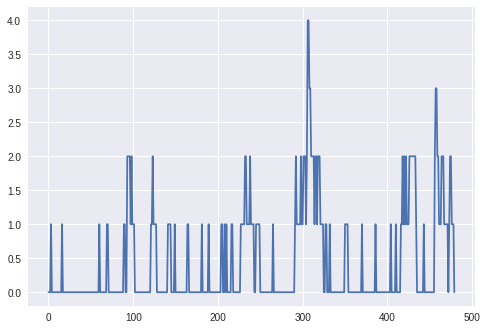

In [0]:
_ = pd.Series(fila_secretaria).plot()

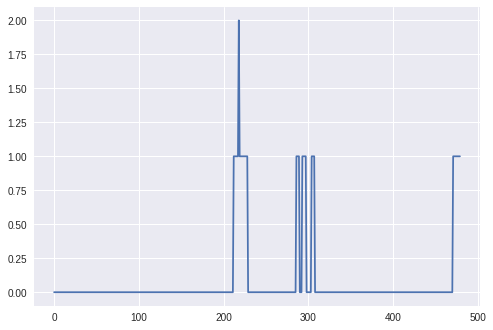

In [0]:
_ = pd.Series(fila_area).plot()

# Exercício 4

Suponha que uma confecção de roupas por encomenda, deseja analisar seu processo de produção.

Os dados são os seguintes:
 * Os pedidos chegam em intervalos de EXPO (12) minutos são feitos os cortes em uma estação de trabalho, daí as peças cortadas são enviadas para a costura, após a costura passam por uma inspeção de qualidade, peças defeituosas são retornadas para a costura para o retrabalho;
 * Tempos de produção:
   * Corte: TRIA (8, 10, 12) minutos;
   * Costura: TRIA (18, 22, 28) minutos;
   * Tempo de inspeção igual a 2 minutos.
 * Número de Funcionários:
   * Corte: 01 funcionário;
   * Costura: 02 funcionários;
   * Inspeção: 01 funcionário.
 * Índice de rejeição na inspeção de qualidade: 20%.
 
Desejamos saber:
 * Qual a taxa de ocupação de cada funcionário?
 * Qual o tamanho médio de cada fila?


In [0]:
def gen_tempo_entre_chegadas(param=12):
    return np.random.exponential(param)
  
def gen_tempo_triangular(param):
    return np.random.triangular(*param)
  
def gen_tempo_inspecao():
    return 2
  
def gen_rejeicao(param=0.2):
    return np.random.uniform() < param

def pedido(env, corte, costura, inspecao):
    rejeitado = True
    while rejeitado:
        with corte.request() as req:
            yield req
            tempo_corte = gen_tempo_triangular([8, 10, 12])
            yield env.timeout(tempo_corte)
        with costura.request() as req:
            yield req
            tempo_costura = gen_tempo_triangular([18, 22, 28])
            yield env.timeout(tempo_corte)
        with inspecao.request() as req:
            yield req
            tempo_inspecao = gen_tempo_inspecao()
            yield env.timeout(tempo_inspecao)
            rejeitado = gen_rejeicao()
  
def confeccao_run(env, corte, costura, inspecao):
    while True:
        env.process(pedido(env, corte, costura, inspecao))
        tempo_entre_chegadas = gen_tempo_entre_chegadas()
        yield env.timeout(tempo_entre_chegadas)

fila_corte = []
fila_costura = []
fila_inspecao = []
def observer(env, corte, costura, inspecao):
    while True:
        fila_corte.append(len(corte.queue))
        fila_costura.append(len(costura.queue))
        fila_inspecao.append(len(inspecao.queue))
        yield env.timeout(1)
        
env = simpy.Environment()
corte = simpy.Resource(env, capacity=1)
costura = simpy.Resource(env, capacity=1)
inspecao = simpy.Resource(env, capacity=1)
env.process(confeccao_run(env, corte, costura, inspecao))
env.process(observer(env, corte, costura, inspecao))
env.run(until=60 * 24)

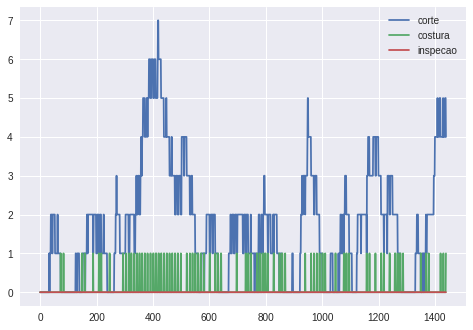

In [0]:
_ = pd.concat([pd.Series(fila_corte, name='corte'),
               pd.Series(fila_costura, name='costura'),
               pd.Series(fila_inspecao, name='inspecao')],
              axis=1).plot()

# Exercício 5

Em um laboratório particular o cliente chega e pede por uma senha comum ou preferencial.

Existe 1 caixa preferencial que só atende clientes comuns caso não exista nenhum preferencial na fila.

Existem outros 3 caixas comuns que apenas podem atender preferenciais caso não exista nenhum cliente comum na fila e caso os outros dois caixas preferenciais estejam ocupados.

Clientes chegam em EXP(1), sendo 75% deles comuns.

Clientes preferenciais e comuns demoram UNIFORM(1, 3) minutos para serem atendidos

In [0]:
def gen_tipo_de_cliente(param=0.25):
    return np.random.uniform() < param

def gen_tempo_entre_chegadas(param=1):
    return np.random.exponential(param)
  
def gen_tempo_no_caixa(param=[1, 4]):
    return np.random.uniform(*param)

espera_comum = []
espera_preferencial = []
def cliente(env, caixa_comum, caixa_preferencial):
    cliente_prefencial = gen_tipo_de_cliente()
    if cliente_prefencial:
        with caixa_preferencial.request() as req:
            start = env.now
            yield req
            espera = env.now - start
            espera_preferencial.append(espera)
            tempo_caixa = gen_tempo_no_caixa()
            yield env.timeout(tempo_caixa)
    else:
        with caixa_comum.request() as req:
            start = env.now
            yield req
            espera = env.now - start
            espera_comum.append(espera)
            tempo_caixa = gen_tempo_no_caixa()
            yield env.timeout(tempo_caixa)
  
def laboratorio_run(env, caixa_comum, caixa_preferencial):
    while True:
        env.process(cliente(env, caixa_comum, caixa_preferencial))
        tempo_entre_chegadas = gen_tempo_entre_chegadas()
        yield env.timeout(tempo_entre_chegadas)

fila_comum = []
fila_preferencial = []
def observer(env, caixa_comum, caixa_preferencial):
    while True:
        fila_comum.append(len(caixa_comum.queue))
        fila_preferencial.append(len(caixa_preferencial.queue))
        yield env.timeout(1)
        
env = simpy.Environment()
caixa_comum = simpy.Resource(env, capacity=3)
caixa_preferencial = simpy.Resource(env, capacity=1)
env.process(laboratorio_run(env, caixa_comum, caixa_preferencial))
env.process(observer(env, caixa_comum, caixa_preferencial))
env.run(until=60 * 8)

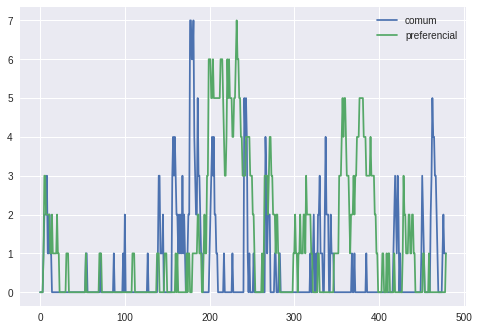

In [0]:
_ = pd.concat([pd.Series(fila_comum, name='comum'),
               pd.Series(fila_preferencial, name='preferencial')],
              axis=1).plot()

In [0]:
pd.concat([pd.Series(espera_comum).describe().rename('comum'),
           pd.Series(espera_preferencial).describe().rename('preferencial').to_frame()],
         axis=1)

,comum,preferencial
count,364.000000,141.000000
mean,0.796327,4.234208
std,1.244190,4.306855
min,0.000000,0.000000
25%,0.000000,0.289336
50%,0.000000,2.994731
75%,1.288960,7.317159
max,6.280139,15.491015


# Exercício 6

Um hospital tem 8 lugares para leitos específicos para cada etapa do protocolo de tratamento de uma doença.

Caso um paciente tenha que ser submetido ao tratamento, precisa ocupar leitos em diferentes salas.

O protocolo de tratamento dessa doença tem 3 fases. Cada fase ocorre em uma sala específica com leitos apropriados.
 * Após a primeira fase, 26% de chance de receber alta. Essa fase dura EXP(4) dias
 * Após a segunda fase, 19% de chance de receber alta. Essa fase dura EXP(6) dias
 * A terceira e última fase dura EXP(15) dias.
 
Suponha inicialmente que a chegada de pacientes com o diagnóstico é EXP(1)

Suponha também uma alocação de leitos (5, 1, 2) (5 para primeira fase, 1 para a segunda e 2 para a terceira)


In [0]:
def gen_tempo(param):
    return np.random.exponential(param)
  
def gen_diagnostico(param):
    return np.random.uniform() < param

  
espera = {'fase1': [],
          'fase2': [],
          'fase3': []}
def paciente(env, leitos1, leitos2, leitos3):
    ## Fase 1
    with leitos1.request() as req:
        start = env.now
        yield req
        espera['fase1'].append(env.now - start)
        tempo_1 = gen_tempo(4)
        yield env.timeout(tempo_1)
    alta = gen_diagnostico(0.9)
    if not alta:
        ## Fase 2
        with leitos2.request() as req:
            start = env.now
            yield req
            espera['fase2'].append(env.now - start)
            tempo_2 = gen_tempo(6)
            yield env.timeout(tempo_2)
        alta = gen_diagnostico(0.26)
        if not alta:
            ## Fase 3
            with leitos3.request() as req:
                start = env.now
                yield req
                espera['fase3'].append(env.now - start)
                tempo_3 = gen_tempo(15)
                yield env.timeout(tempo_3)

def hospital_run(env, leitos1, leitos2, leitos3):
    while True:
        env.process(paciente(env, leitos1, leitos2, leitos3))
        tempo_entre_chegadas = gen_tempo(1)
        yield env.timeout(tempo_entre_chegadas)

fila = {'fase1': [],
        'fase2': [],
        'fase3': []}
def observer(env, leitos1, leitos2, leitos3):
    while True:
        fila['fase1'].append(len(leitos1.queue))
        fila['fase2'].append(len(leitos2.queue))
        fila['fase3'].append(len(leitos3.queue))
        yield env.timeout(1)
        
env = simpy.Environment()
leitos1 = simpy.Resource(env, capacity=5)
leitos2 = simpy.Resource(env, capacity=1)
leitos3 = simpy.Resource(env, capacity=2)
env.process(hospital_run(env, leitos1, leitos2, leitos3))
env.process(observer(env, leitos1, leitos2, leitos3))
env.run(until=360)

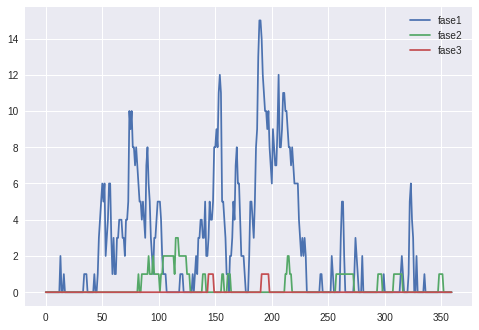

In [0]:
_ = pd.concat([pd.Series(fila[x], name=x) for x in fila],
              axis=1).plot()

In [0]:
pd.concat([pd.Series(espera[x], name=x).describe().to_frame() for x in espera],
          axis=1)

,fase1,fase2,fase3
count,405.000000,37.000000,20.000000
mean,2.252765,3.116215,0.561877
std,2.640666,4.191379,1.428041
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.167870,1.205764,0.000000
75%,4.000148,4.474737,0.000000
max,9.936356,14.164788,4.996038


# Exercício 7

Em um fábrica chegam pedidos a cada EXPO (23) minutos e vão para a produção, gastando UNIF (15, 25) minutos. A seguir passam por um processo de inspeção, em que demoram TRIA (15, 17, 20) minutos para serem inspecionados, tendo um percentual de falha de 30%. As peças defeituosas vão para uma estação de reparo. As peças sem defeito vão para a expedição. Na estação de reparo se gasta UNIF (10, 15) minutos e, a seguir, as peças vão para a expedição. Simule 1000 minutos. Pede-se:
 * Qual a taxa de ocupação de cada servidor?
 * Qual o tamanho médio de cada fila?
 * Qual o tempo médio em cada fila?

In [0]:
def gen_tempo_expo(param):
    return np.random.exponential(param)
  
def gen_tempo_trian(param):
    return np.random.triangular(*param)
  
def gen_tempo_uniform(param):
    return np.random.uniform(*param)
  
def gen_falha(param):
    return np.random.uniform() < param

espera = {'producao': [],
          'inspecao': [],
          'reparos': []}
def order(env, producao, inspecao, reparos):
    with producao.request() as req:
        start = env.now
        yield req
        espera['producao'].append(env.now - start)
        yield env.timeout(gen_tempo_uniform([15, 25]))

    with inspecao.request() as req:
        start = env.now
        yield req
        espera['inspecao'].append(env.now - start)
        yield env.timeout(gen_tempo_trian([15, 17, 20]))

    falha = gen_falha(0.3)
    if falha:
        with reparos.request() as req:
            start = env.now
            yield req
            espera['reparos'].append(env.now - start)
            yield env.timeout(gen_tempo_uniform([10, 15]))
  
def fabrica_run(env, producao, inspecao, reparos):
    while True:
        env.process(order(env, producao, inspecao, reparos))
        yield env.timeout(gen_tempo_expo(23))

fila = {'producao': [],
        'inspecao': [],
        'reparos': []}
def observer(env, producao, inspecao, reparos):
    while True:
        fila['producao'].append(len(producao.queue))
        fila['inspecao'].append(len(inspecao.queue))
        fila['reparos'].append(len(reparos.queue))
        yield env.timeout(1)
        
env = simpy.Environment()
producao = simpy.Resource(env, capacity=1)
inspecao = simpy.Resource(env, capacity=1)
reparos = simpy.Resource(env, capacity=1)
env.process(fabrica_run(env, producao, inspecao, reparos))
env.process(observer(env, producao, inspecao, reparos))
env.run(until=60 * 24 * 30)

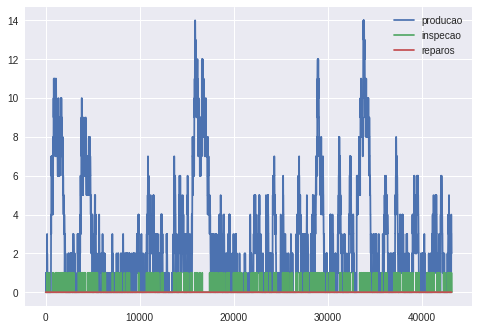

In [0]:
_ = pd.concat([pd.Series(fila[x], name=x) for x in fila],
              axis=1).plot()

In [0]:
pd.concat([pd.Series(espera[x], name=x).describe().to_frame() for x in espera],
          axis=1)

,producao,inspecao,reparos
count,1844.000000,1843.000000,502.0
mean,55.386541,0.426221,0.0
std,57.789709,1.089573,0.0
min,0.000000,0.000000,0.0
25%,11.385738,0.000000,0.0
50%,35.370729,0.000000,0.0
75%,81.480149,0.000000,0.0
max,276.182647,10.507692,0.0


# Exercício 8

Uma central de atendimento de emergência recebe uma chamada em média a cada 15 minutos seguindo uma distribuição exponencial. Os tipos de chamadas possuem as seguintes características:

| Tipo de Chamada              | Porcentagem das Chamadas | Tempo de Atendimento (min.) |
|------------------------------|--------------------------|-----------------------------|
| Falsa                        | 15% do total de chamadas | TRIA(10; 11; 13)            |
| Emergência sem risco de vida | 85% das não falsas       | NORMAL(25; 1)               |
| Emergência com risco de vida | 15% das não falsas       | TRIA(18; 21; 30)            |

Pede-se:
 * Dimensione o número de atendentes para que a média do tempo de espera por atendimento seja menor que 1 minuto.


In [0]:
def gen_tempo(tipo, params):
    if tipo == 'norm':
        return np.random.normal(*params)
    elif tipo == 'exp':
        return np.random.exponential(params)
    elif tipo == 'uniform':
        return np.random.uniform(*params)
    elif tipo == 'trian':
        return np.random.triangular(*params)

espera = []
def atendimento(env, atendentes):
    with atendentes.request() as req:
        start = env.now
        yield req
        espera.append(env.now - start)
        if np.random.uniform() < 0.15:
            yield env.timeout(gen_tempo('trian', [10, 11, 13]))
        elif np.random.uniform() < 0.85:
            yield env.timeout(gen_tempo('norm', [25, 1]))
        else:
            yield env.timeout(gen_tempo('trian', [18, 21, 30]))

def emergencia_run(env, atendentes):
    while True:
        env.process(atendimento(env, atendentes))
        yield env.timeout(gen_tempo('exp', 15))

fila = []
def observer(env, atendentes):
    while True:
        fila.append(len(atendentes.queue))
        yield env.timeout(1)
        
env = simpy.Environment()
atendentes = simpy.Resource(env, capacity=4)
env.process(emergencia_run(env, atendentes))
env.process(observer(env, atendentes))
env.run(until=60 * 24 * 30)

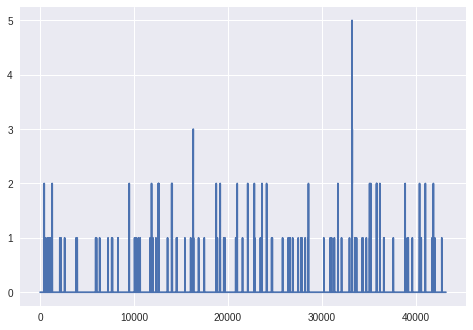

In [0]:
_ = pd.Series(fila).plot()

In [0]:
pd.Series(espera).describe().rename('Espera').to_frame()

,Espera
count,2828.000000
mean,0.377704
std,1.912799
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,25.028772


# Exercício 9

Um sistema possui duas máquinas (A e B) com suas respectivas filas.

Dois tipos de entidades entram no sistema: Tipo I e Tipo II.

Na fila da máquina A, somente são aceitas entidades do Tipo I.

Já a máquina B, aceita os dois tipos de entidades.
 * Sempre que uma entidade do Tipo I entra no sistema se a fila da máquina A estiver menor que a fila da outra máquina então ela é processada na máquina A, caso contrário na máquina B.
 
As entidades chegam a cada 10 minutos seguindo uma distribuição exponencial, sendo 50% das entidades do Tipo I e os outros 50% do Tipo II.

O tempo de processamento na máquina A segue uma distribuição normal com média 8 e desvio padrão de 2 minutos.

O tempo de processamento na máquina B segue uma média de 6.5 minutos com desvio padrão de 2 minutos também seguindo uma distribuição normal.

Simule este sistema por 10 dias funcionando 24 horas por dia.

Colete as estatísticas em minutos.

Verifique a ocupação das máquinas bem como os tempos médios nas filas e os números médios de entidades nas filas.


In [0]:
def gen_tempo(tipo, params):
    if tipo == 'norm':
        return np.random.normal(*params)
    elif tipo == 'exp':
        return np.random.exponential(params)
    elif tipo == 'uniform':
        return np.random.uniform(*params)
    elif tipo == 'trian':
        return np.random.triangular(*params)

def gen_tipo(param):
    return 'I' if np.random.uniform() < param else 'II'

espera = {'maquina_A': [],
          'maquina_B': []}
def entidade(env, tipo, maquina_A, maquina_B):
    if tipo == 'II':
        with maquina_B.request() as req:
            start = env.now
            yield req
            espera['maquina_B'].append(env.now - start)
            yield env.timeout(gen_tempo('norm', [6.5, 2]))
    elif tipo == 'I':
        if len(maquina_A.queue) < len(maquina_B.queue):
            with maquina_A.request() as req:
                start = env.now
                yield req
                espera['maquina_A'].append(env.now - start)
                yield env.timeout(gen_tempo('norm', [8, 2]))
        else:
            with maquina_B.request() as req:
                start = env.now
                yield req
                espera['maquina_B'].append(env.now - start)
                yield env.timeout(gen_tempo('norm', [6.5, 2]))
  
def fabrica_run(env, maquina_A, maquina_B):
    while True:
        tipo = gen_tipo(0.5)
        env.process(entidade(env, tipo, maquina_A, maquina_B))
        yield env.timeout(gen_tempo('exp', 10))

fila = {'maquina_A': [],
        'maquina_B': []}
def observer(env, maquina_A, maquina_B):
    while True:
        fila['maquina_A'].append(len(maquina_A.queue))
        fila['maquina_B'].append(len(maquina_B.queue))
        yield env.timeout(1)

env = simpy.Environment()
maquina_A = simpy.Resource(env, capacity=1)
maquina_B = simpy.Resource(env, capacity=1)
env.process(fabrica_run(env, maquina_A, maquina_B))
env.process(observer(env, maquina_A, maquina_B))
env.run(until=60 * 24 * 10)

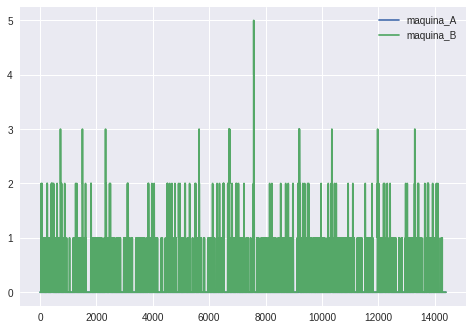

In [0]:
_ = pd.concat([pd.Series(fila[x], name=x) for x in fila],
              axis=1).plot()

In [0]:
pd.concat([pd.Series(espera[x], name=x).describe().to_frame() for x in espera],
          axis=1)

,maquina_A,maquina_B
count,154.000000,1299.000000
mean,1.186551,2.847444
std,2.970110,3.833268
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.712867
75%,0.000000,4.868109
max,14.616625,28.034655


Entre duas cidades, A e B, existe um número fixo(N) de linhas telefônicas.

Cada linha pode operar em ambas as direções, isto é, origem em A e B, mas somente com uma chamada por vez.
 * Se uma pessoa deseja fazer uma chamada e houver uma linha disponível, a chamada é completada imediatamente.
 * Se todas as n linhas estiverem ocupadas, pessoa recebe uma gravação dizendo para ela desligar e tentar mais tarde.
 
Não existe dispositivo de espera, isto é, chamadas bloqueadas por falta de linhas são perdidas.

Os tempos entre as tentativas de chamadas
 * de A para B seguem uma exponencial (10) seg., enquanto que as
 * de B para A uma exponencial (4) min.
 
O tempo da chamada é de exponencial com 5 min.

Inicialmente, todas as linhas estão disponíveis.

A simulação deve ser executada por 24h com 30 min de aquecimento (warm-up).

Inicie com N=10.

Determine:
 * a taxa de ocupação das linhas,
 * o número total de chamadas por cidade de origem,
 * o número de chamadas bloqueadas e
 * a proporção destas em relação ao total de chamadas (bloqueadas + completadas).

In [0]:
num_chamadas_a_to_b = 0
num_chamadas_b_to_a = 0
num_bloqueadas = 0

def chamada(env, linhas):
    global num_bloqueadas
    if len(linhas.queue) == 0:
        with linhas.request() as req:
            yield req
            yield env.timeout(gen_tempo('exp', 60 * 5))
    else:
        num_bloqueadas += 1

def chamadas_a_to_b(env, linhas):
    global num_chamadas_a_to_b
    while True:
        env.process(chamada(env, linhas))
        yield env.timeout(gen_tempo('exp', 10))
        num_chamadas_a_to_b += 1
        
def chamadas_b_to_a(env, linhas):
    global num_chamadas_b_to_a
    while True:
        env.process(chamada(env, linhas))
        yield env.timeout(gen_tempo('exp', 4))
        num_chamadas_b_to_a += 1

fila = []
def observer(env, linhas):
    while True:
        fila.append(len(linhas.queue))
        yield env.timeout(60 * 60)

env = simpy.Environment()
linhas = simpy.Resource(env, capacity=2)
env.process(chamadas_a_to_b(env, linhas))
env.process(chamadas_b_to_a(env, linhas))
env.process(observer(env, linhas))
env.run(until=60 * 60 * 24)

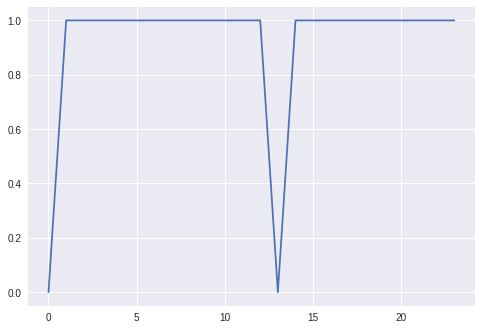

In [0]:
_ = pd.Series(fila).plot()

In [0]:
print(num_chamadas_a_to_b, num_chamadas_b_to_a, num_bloqueadas)

8706 21524 29658
